In [1]:
!pip3 install fast-tabnet

In [2]:
from fastai2.basics import *
from fastai2.tabular.all import *
from fast_tabnet.core import *

In [3]:
BATCH_SIZE = 1024 
EPOCHS = 150
LR = 0.02
seed = 2020   # seed for reproducible results
patience = 50
device = torch.device('cuda')
FOLDS = 5
fold = 0

In [4]:
# Defining Categorical variables and their Indexes, embedding dimensions , number of classes each have
df = pd.read_csv('/data/full/folds_13062020.csv')
df.head()

,image_id,patient_id,target,source,sex,age_approx,anatom_site_general_challenge,stratify_group,fold
0,ISIC_2637011,IP_7279968,0,ISIC20,male,45.0,head/neck,31,0
1,ISIC_0015719,IP_3075186,0,ISIC20,female,45.0,upper extremity,7,2
2,ISIC_0052212,IP_2842074,0,ISIC20,female,50.0,lower extremity,5,4
3,ISIC_0068279,IP_6890425,0,ISIC20,female,45.0,head/neck,7,0
4,ISIC_0074268,IP_8723313,0,ISIC20,female,55.0,upper extremity,6,4


In [5]:
df_test =pd.read_csv('/data/full/test.csv')

In [6]:
def get_fold_dls(df_train, df_test, fold):
    cat_names = ['sex', 'anatom_site_general_challenge']
    cont_names = ['age_approx']
    procs = [Categorify, FillMissing, Normalize]
    y_names = 'target'
    splits = (L(df[df.fold != fold].index.tolist()), L(df[df.fold == fold].index.tolist()))
    to = TabularPandas(df, procs, cat_names, cont_names, y_names, y_block=CategoryBlock(), splits=splits)
    dls = to.dataloaders()

    

In [7]:
cat_names = ['sex', 'anatom_site_general_challenge']
cont_names = ['age_approx']
procs = [Categorify, FillMissing, Normalize]
y_names = 'target'
splits = (L(df[df.fold != fold].index.tolist()), L(df[df.fold == fold].index.tolist()))

In [8]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names, y_block=CategoryBlock(), splits=splits)

In [9]:
dls = to.dataloaders()
dls.valid.show_batch()

,sex,anatom_site_general_challenge,age_approx,target
0,male,head/neck,45.000000,0
1,female,head/neck,45.000000,0
2,male,lower extremity,25.000001,0
3,female,lower extremity,50.000000,0
4,female,torso,55.000000,0
5,male,torso,45.000000,0
6,male,torso,45.000000,0
7,female,unknown,30.000000,0
8,male,head/neck,45.000000,0
9,male,torso,65.000000,0


In [10]:
to_tst = to.new(df_test)
to_tst.process()
to_tst.all_cols.head()

,sex,anatom_site_general_challenge,age_approx
0,2,0,1.160915
1,2,3,-0.692332
2,1,6,0.234291
3,1,6,-0.074583
4,1,3,-0.383458


In [11]:
to_tst.all_cols

,sex,anatom_site_general_challenge,age_approx
0,2,0,1.160915
1,2,3,-0.692332
2,1,6,0.234291
3,1,6,-0.074583
4,1,3,-0.383458
...,...,...,...
10977,2,6,-0.692332
10978,2,6,-1.001207
10979,2,8,-1.618956
10980,2,3,0.852040


In [12]:
emb_szs = get_emb_sz(to); print(emb_szs)

[(4, 3), (9, 5)]


In [13]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=32, n_a=32, n_steps=4); 

In [18]:
model.fi

ModuleAttributeError: 'TabNetModel' object has no attribute 'final_mapping'

In [14]:
from sklearn.metrics import roc_auc_score
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

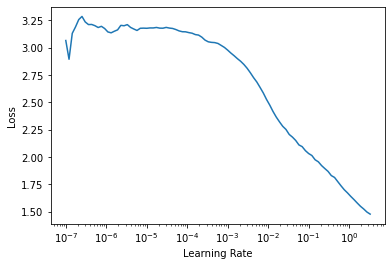

In [15]:
lr, lr_step = learn.lr_find()

In [16]:
lr, lr_step

(0.33113112449646, 0.007585775572806597)

In [17]:
learn.fit_one_cycle(30, lr, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=5), SaveModelCallback(monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,time
0,0.291589,0.331136,0.893044,00:30
1,0.291882,0.336500,0.908424,00:30
2,0.281767,0.310598,0.908424,00:30
3,0.288700,0.303754,0.908424,00:30
4,0.271825,0.299685,0.908424,00:30
5,0.283678,0.297319,0.908424,00:30
6,0.291710,15.182920,0.091576,00:31
7,0.319771,0.297163,0.908424,00:30
8,0.332169,4.758911,0.629588,00:30
9,0.294238,139.953720,0.091576,00:30


Better model found at epoch 0 with valid_loss value: 0.33113646507263184.
Better model found at epoch 2 with valid_loss value: 0.3105982840061188.
Better model found at epoch 3 with valid_loss value: 0.30375373363494873.
Better model found at epoch 4 with valid_loss value: 0.2996850609779358.
Better model found at epoch 5 with valid_loss value: 0.2973194420337677.
Better model found at epoch 7 with valid_loss value: 0.2971629202365875.
No improvement since epoch 7: early stopping


In [18]:
learn.show_results()

,sex,anatom_site_general_challenge,age_approx,target,target_pred
0,1.0,8.0,-1.310082,0.0,0.0
1,2.0,6.0,1.469790,0.0,0.0
2,2.0,1.0,-0.692332,1.0,0.0
3,2.0,3.0,1.160915,0.0,0.0
4,1.0,1.0,-1.001207,0.0,0.0
5,2.0,3.0,-0.074583,1.0,0.0
6,2.0,5.0,0.543166,0.0,0.0
7,1.0,7.0,-0.074583,0.0,0.0
8,2.0,1.0,1.778664,0.0,0.0


In [19]:
preds, _ = learn.get_preds()

In [20]:
preds[:, 1].max()

tensor(0.2407)

In [21]:
test_dl = dls.test_dl(to_tst.all_cols, shuffle=False)

In [22]:
preds, targs, logits = learn.get_preds(dl=test_dl, reorder=False, with_decoded=True)